In [1]:
# Code source: https://github.com/scikit-image/skimage-demos/tree/master/pano
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


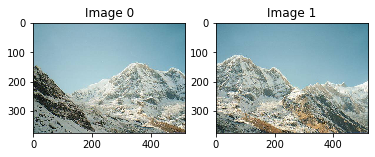

In [2]:
I0 = io.imread("/content/drive/My Drive/CMPUT206_2020/Week06/Picture1.jpg")
I1 = io.imread("/content/drive/My Drive/CMPUT206_2020/Week06/Picture2.jpg")

%matplotlib inline
fig=plt.figure()
plt.subplot(121)
plt.imshow(I0)
plt.title("Image 0")
plt.subplot(122)
plt.imshow(I1)
plt.title("Image 1")
plt.show()

In [0]:
from skimage.color import rgb2gray

pano0 = rgb2gray(I0)
pano1 = rgb2gray(I1)

In [0]:
from skimage.feature import ORB

# Initialize ORB
# 800 keypoints is large enough for robust results, 
# but low enough to run within a few seconds. 
orb = ORB(n_keypoints=800, fast_threshold=0.05)

# Detect keypoints in pano0
orb.detect_and_extract(pano0)
keypoints0 = orb.keypoints
descriptors0 = orb.descriptors

# Detect keypoints in pano1
orb.detect_and_extract(pano1)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

In [0]:
from skimage.feature import match_descriptors

# Match descriptors between images
matches01 = match_descriptors(descriptors0, descriptors1, cross_check=True)

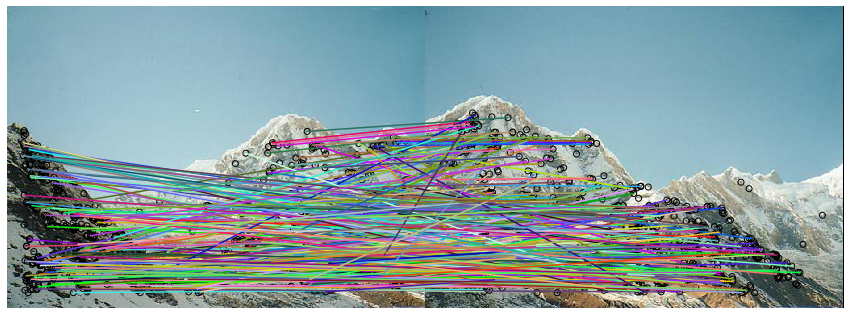

In [6]:
from skimage.feature import plot_matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano0 -> pano1
plot_matches(ax, I0, I1, keypoints0, keypoints1, matches01)
ax.axis('off');

In [0]:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

# Select keypoints from 
#   * source (image to be registered): pano1
#   * target (reference image): pano0
src = keypoints1[matches01[:, 1]][:, ::-1]
dst = keypoints0[matches01[:, 0]][:, ::-1]

model_robust01, inliers01 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)


In [0]:
print(model_robust01)

<ProjectiveTransform(matrix=
    [[ 9.35898680e-01, -1.52989371e-01,  3.36930771e+02],
     [-1.90685725e-01,  8.11943268e-01,  8.17401771e+01],
     [-1.11296129e-04, -9.12839506e-04,  1.24710057e+00]])>


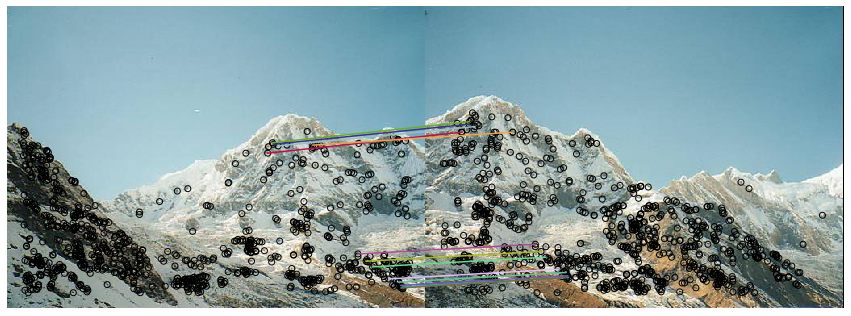

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano0 -> pano1
plot_matches(ax, I0, I1, keypoints0, keypoints1, matches01[inliers01])

ax.axis('off');

In [0]:
from skimage.transform import SimilarityTransform

# Shape registration target
r, c = pano0.shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions
warped_corners01 = model_robust01(corners)

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack((warped_corners01, corners))

# The overally output shape will be max - min
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)

# Ensure integer shape with np.ceil and dtype conversion
output_shape = np.ceil(output_shape[::-1]).astype(int)

In [0]:
print(output_shape)

[442 904]


In [0]:
from skimage.transform import warp

# This in-plane offset is the only necessary transformation for the middle image
offset1 = SimilarityTransform(translation= -corner_min)


# Warp pano1 to pano0 using 3rd order interpolation
transform01 = (model_robust01 + offset1).inverse  
I1_warped = warp(I1, transform01, order=3,
                    output_shape=output_shape, cval=-1)

I1_mask = (I1_warped != -1)  # Mask == 1 inside image
I1_warped[~I1_mask] = 0      # Return background values to 0


# Translate pano0 into place
I0_warped = warp(I0, offset1.inverse, order=3,
                    output_shape=output_shape, cval=-1)

I0_mask = (I0_warped != -1)  # Mask == 1 inside image
I0_warped[~I0_mask] = 0      # Return background values to 0


In [0]:
print(I1_warped.shape)

(442, 904, 3)


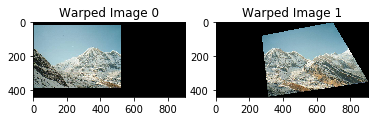

In [0]:
%matplotlib inline
fig=plt.figure()
plt.subplot(121)
plt.imshow(I0_warped)
plt.title("Warped Image 0")
plt.subplot(122)
plt.imshow(I1_warped)
plt.title("Warped Image 1")
plt.show()

In [0]:
# Add the images together. This could create dtype overflows!
# We know they are are floating point images after warping, so it's OK.
merged = (I0_warped + I1_warped)

# Track the overlap by adding the masks together
overlap = (I0_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           I1_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)

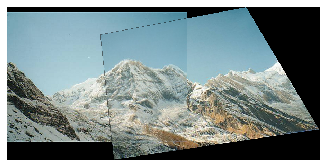

In [0]:
fig, ax = plt.subplots(figsize=(5, 10))

ax.imshow(normalized)

plt.tight_layout()
ax.axis('off');